# Soret effect

This task will demonstrate how to setup a FESTIM model including the Soret effect.

When including the Soret effect, the flux of hydrogen is not only driven by the gradient of concentration:
$$
J = -D \nabla c_\mathrm{m} - D\frac{Q^* c_\mathrm{m}}{k_B T^2} \nabla T
$$

In other words, the hydrogen flux goes from hot regions to cold regions.

We will model a 6 mm slab in steady state with $c=0$ on the boundaries and a volumetric source of particle representing a plasma implantation in the first few nanometres.

## FESTIM model

Let's start with a mesh, a volumetric source and the boundary conditions.

In [1]:
import festim as F

my_model = F.Simulation()

import numpy as np

vertices = np.concatenate(
    [
        np.linspace(0, 30e-9, num=200),
        np.linspace(30e-9, 3e-6, num=300),
        np.linspace(3e-6, 6e-3, num=200),
    ]
)

my_model.mesh = F.MeshFromVertices(vertices)

source_term = F.ImplantationFlux(
    flux=2.5e19, imp_depth=4.5e-9, width=2.5e-9, volume=1
)

my_model.sources = [source_term]

my_model.boundary_conditions = [F.DirichletBC(surfaces=[1, 2], value=0, field=0)]

For this example, we will choose a very high temperature gradient. The temperature will evolve linearly from 1200 K to 300 K over the domain. 

In [2]:
T_val = lambda x: 1200 - 900 * x / 6e-3
my_model.T = T_val(F.x)

In FESTIM, the Soret coefficient (also called heat of diffusion) is set in the ``Q`` argument of ``F.Material`` in units eV.
It can take a float or a function of temperature. Here we choose $Q^* = -0.0045 \ k_B \ T^2$.

It is also important to set the Soret flag to True in the simulation settings.

In [3]:
my_model.materials = F.Material(
    id=1,
    D_0=2.83e-7,  # m2/s
    E_D=0.38,  # eV,
    Q=lambda T: -0.0045 * F.k_B * T**2, # eV
)

my_model.settings = F.Settings(
    absolute_tolerance=1e8,
    relative_tolerance=1e-09,
    transient=False,
    soret=True,
)


Let's now add a few exports and run the model:

In [4]:
derived_quantities = F.DerivedQuantities(
    [F.TotalVolume("solute", volume=1)],
    show_units=True,
)

txt_export = F.TXTExport(field="solute", filename="task12/profile_soret.txt")

my_model.exports = [derived_quantities, txt_export]

my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


Let's run the same simulation but without the Soret effect:

In [5]:
my_model.settings.soret = False
txt_export.filename = "task12/profile_no_soret.txt"
my_model.materials[0].Q = None
my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


## Results

We can plot the steady-state concentration profiles with or without the Soret effect included.
With very high gradients (and the Soret coefficient that was used for this demo), it is clear that neglecting the Soret effect could have a huge impact on the results.

/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


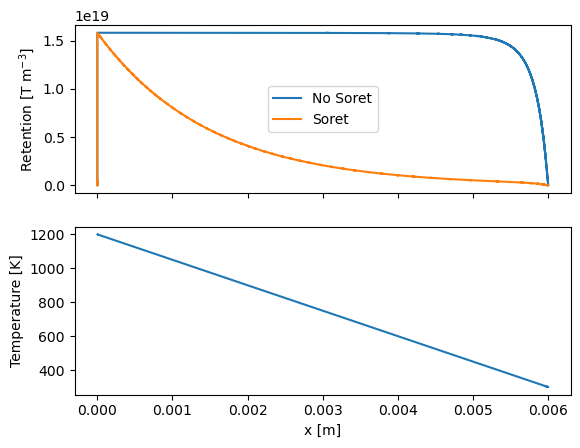

In [6]:
import matplotlib.pyplot as plt

data = np.genfromtxt("task12/profile_soret.txt", delimiter=",", names=True)
data_no_soret = np.genfromtxt("task12/profile_no_soret.txt", delimiter=",", names=True)

name = data_no_soret.dtype.names[1]

fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].plot(data_no_soret["x"], data_no_soret[name], label="No Soret")

name = data.dtype.names[1]
axs[0].plot(data["x"], data[name], label="Soret")

axs[0].legend()
axs[0].set_ylabel("Retention [T m$^{-3}$]")

axs[1].plot(data["x"], T_val(data["x"]))
axs[1].set_xlabel("x [m]")
axs[1].set_ylabel("Temperature [K]")
plt.show()
